In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import scipy.io as sio
import skimage.io

from Preprocess_Utilities import *

In [2]:
# data path
route_path = "../Data/090085/"
road_type = np.array(["motorway", "trunk", "primary", "secondary", "tertiary", "unclassified", "track", # 0-6
                      "residential", "service", "road", "living_street", # 7-10
                      "all_roads"]) # 11 
#                       "motor_trunk_pri_sec_tert_uncl_track", "motor_trunk_pri_sec_tert_uncl"]) # 12-13

path_raw_image = route_path + "090085_20170531.h5"
path_road_mask = np.char.add(np.char.add(np.char.add(route_path+"Road_Data/",road_type),
                                         np.char.add('/', road_type)), '.tif')

In [3]:
# read in raw image
raw_image = np.array(h5py.File(path_raw_image)['scene'])

# read in road mask
road_img_list = []
for cur_path in path_road_mask:
    print(cur_path)
    road_img_list.append(skimage.io.imread(cur_path))

road_img_list = np.array(road_img_list)

# assert 0-1 coding
assert (np.logical_or(road_img_list == 1, road_img_list == 0)).all()

../Data/090085/Road_Data/motorway/motorway.tif
../Data/090085/Road_Data/trunk/trunk.tif
../Data/090085/Road_Data/primary/primary.tif
../Data/090085/Road_Data/secondary/secondary.tif
../Data/090085/Road_Data/tertiary/tertiary.tif
../Data/090085/Road_Data/unclassified/unclassified.tif
../Data/090085/Road_Data/track/track.tif
../Data/090085/Road_Data/residential/residential.tif
../Data/090085/Road_Data/service/service.tif
../Data/090085/Road_Data/road/road.tif
../Data/090085/Road_Data/living_street/living_street.tif
../Data/090085/Road_Data/all_roads/all_roads.tif


In [4]:
print(type(raw_image), raw_image.shape)
print(type(road_img_list), road_img_list.shape)

<class 'numpy.ndarray'> (7, 7961, 8091)
<class 'numpy.ndarray'> (12, 7961, 8091)


In [5]:
# combine the road mask
print("Used labels:")
combined_road_mask = 0
for i in range(5):
    print(path_road_mask[i])
    combined_road_mask += road_img_list[i]
print(combined_road_mask.shape, (combined_road_mask > 1).any())

combined_road_mask[np.where(combined_road_mask > 1)] = 1
assert (np.logical_or(combined_road_mask == 1, combined_road_mask == 0)).all()

Used labels:
../Data/090085/Road_Data/motorway/motorway.tif
../Data/090085/Road_Data/trunk/trunk.tif
../Data/090085/Road_Data/primary/primary.tif
../Data/090085/Road_Data/secondary/secondary.tif
../Data/090085/Road_Data/tertiary/tertiary.tif
(7961, 8091) True


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ../Data/090085/Road_Data/motor_trunk_pri_sec_tert/motor_trunk_pri_sec_tert.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


True


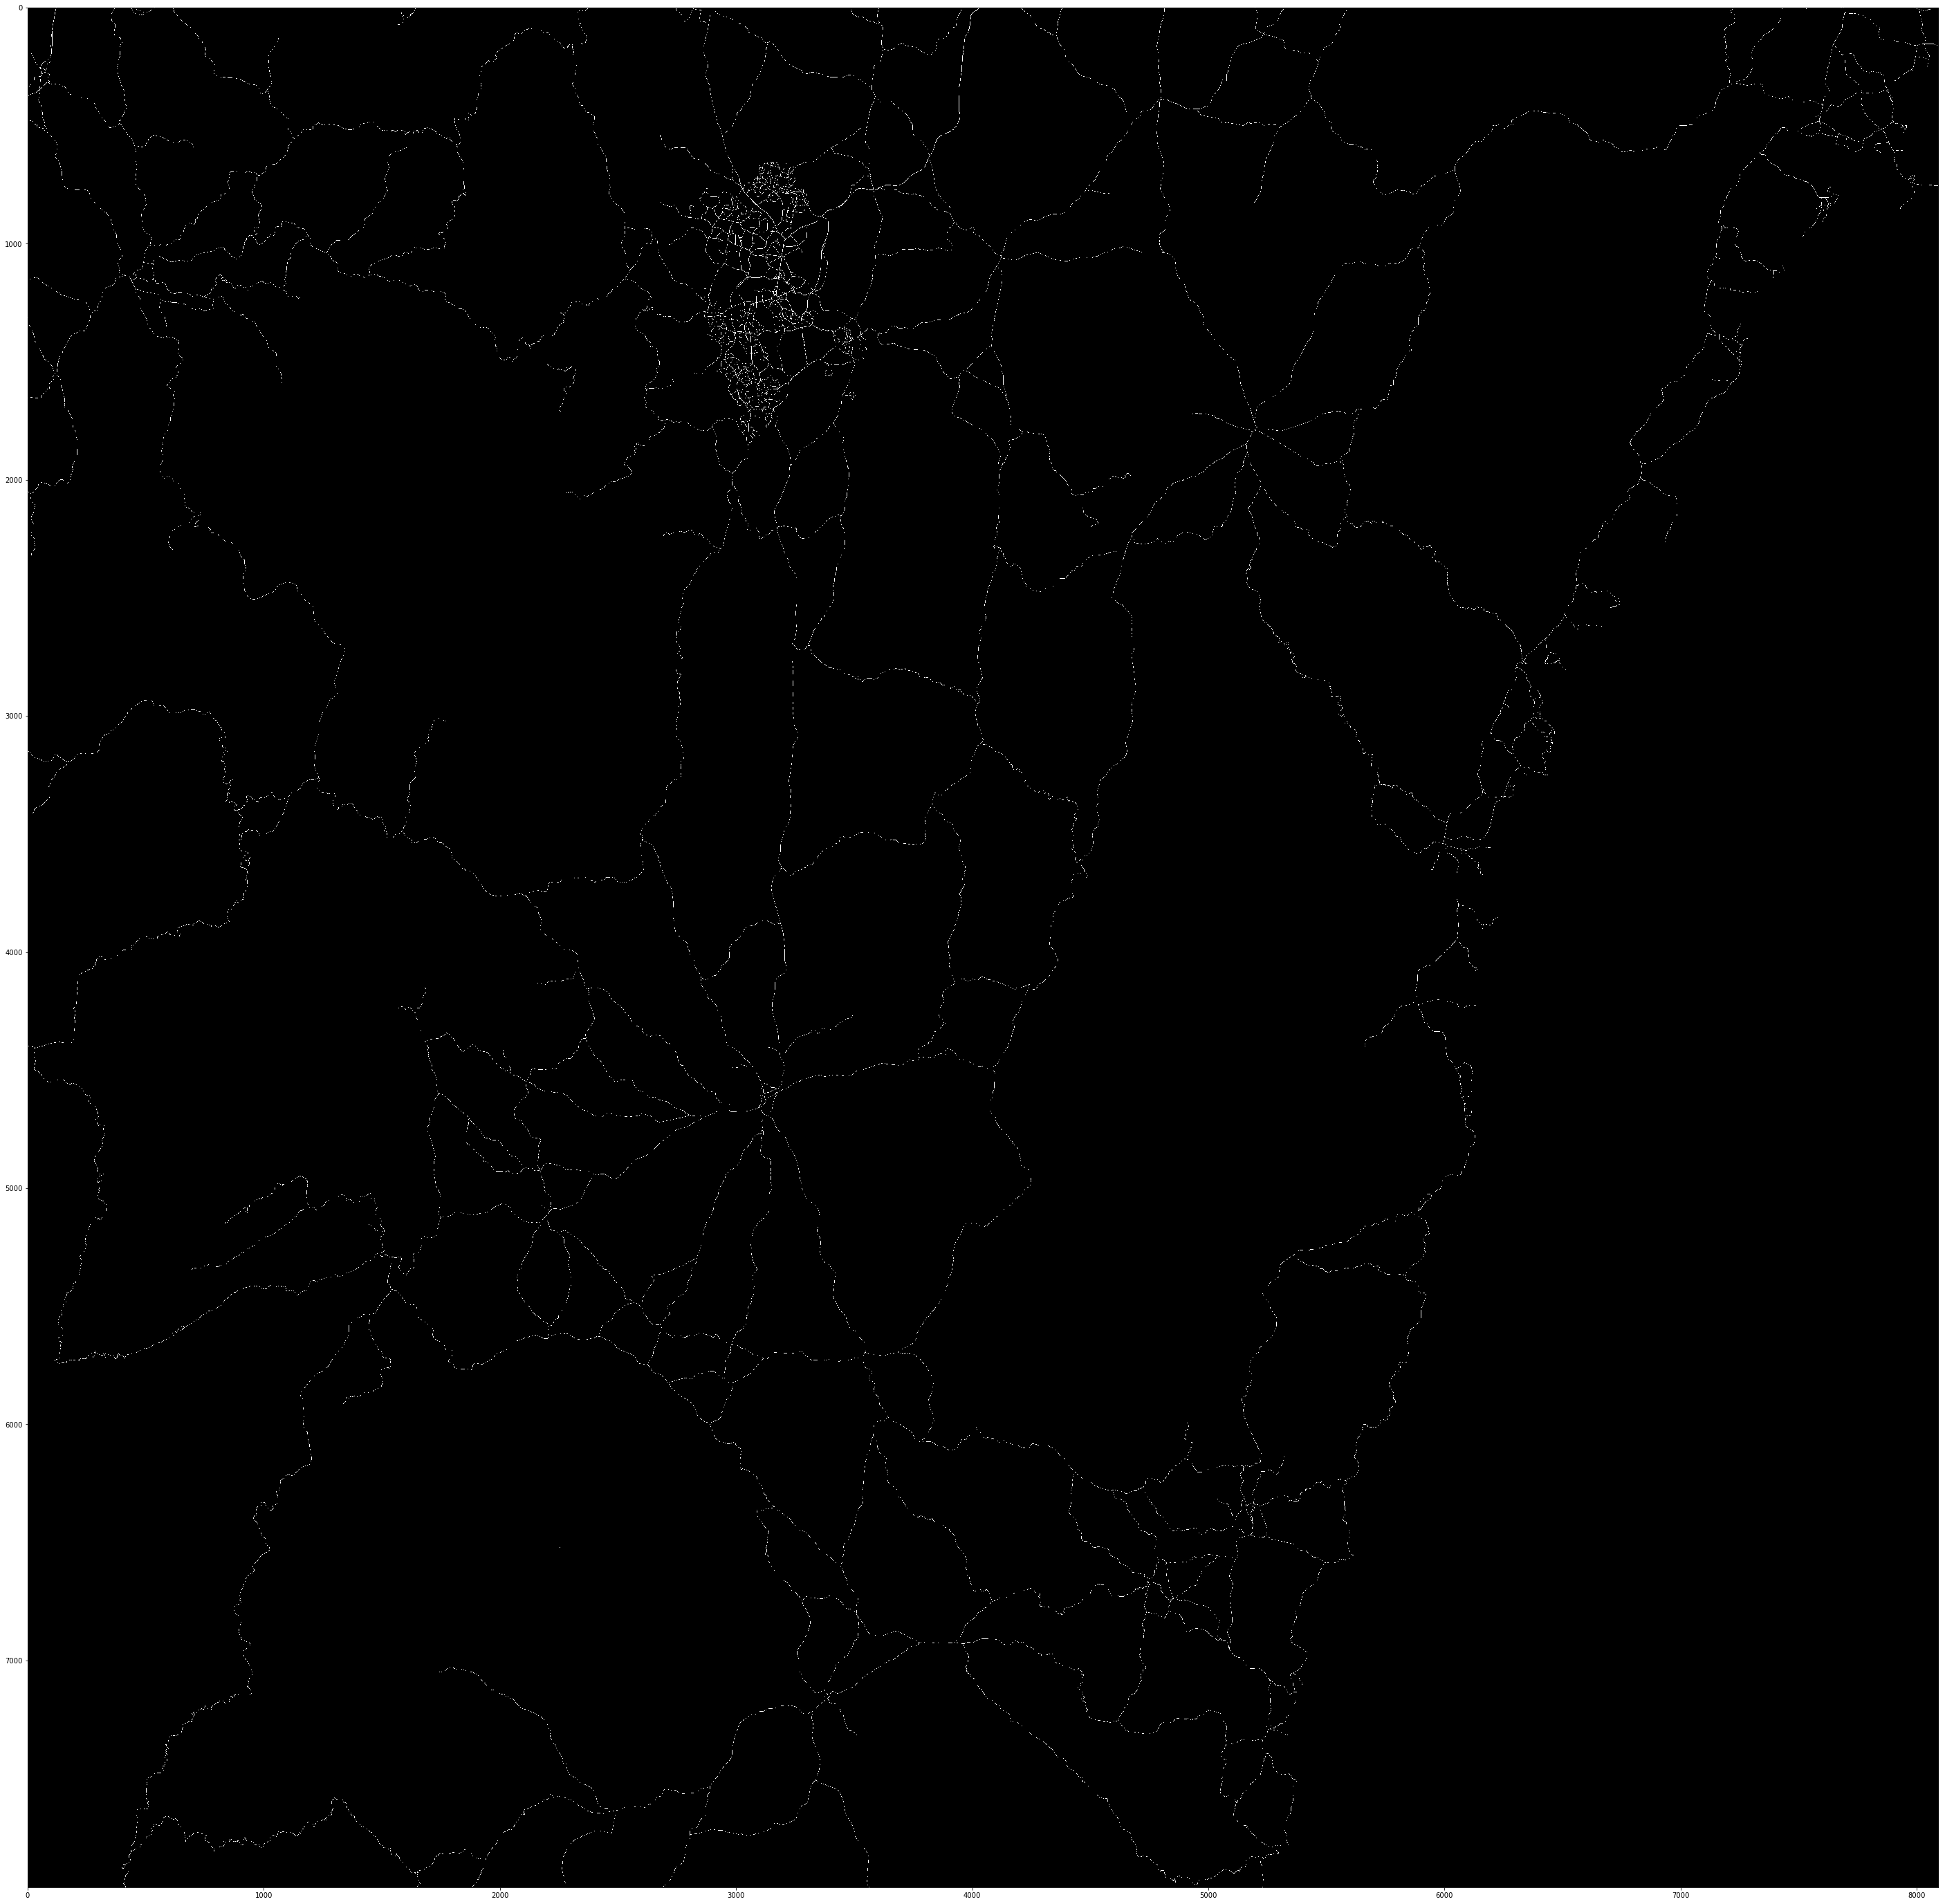

In [6]:
# save the combined road mask
save_path = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert/motor_trunk_pri_sec_tert.tif"
skimage.io.imsave(save_path, combined_road_mask)

skimg_mask = skimage.io.imread(save_path)
print((skimg_mask == combined_road_mask).all())
assert (np.logical_or(skimg_mask == 1, skimg_mask == 0)).all()

plt.figure(figsize=(50,50))
plt.imshow(combined_road_mask, cmap=plt.get_cmap('gray'))
plt.show()

In [7]:
# record the top-left coordinate of each possible patches & calculate mu, sigma
step = 28
pos_topleft_coordinate = []
neg_topleft_coordinate = []

row_offset = 0
while (row_offset + step <= raw_image.shape[1]):
    col_offset = 0
    while (col_offset + step <= raw_image.shape[2]):
        cur_img_patch = raw_image         [:,row_offset:row_offset+step, col_offset:col_offset+step]
        cur_road_mask = combined_road_mask[  row_offset:row_offset+step, col_offset:col_offset+step]
        
        if (cur_img_patch != -9999).all():
            if cur_road_mask [int(step/2), int(step/2)] == 1: # positive example
                pos_topleft_coordinate.append((row_offset, col_offset))
            else: # negative example
                neg_topleft_coordinate.append((row_offset, col_offset))
        
        col_offset += 1
    row_offset += 1

pos_topleft_coordinate = np.array(pos_topleft_coordinate)
neg_topleft_coordinate = np.array(neg_topleft_coordinate)
print(pos_topleft_coordinate.shape, neg_topleft_coordinate.shape)

(66299, 2) (17088097, 2)


In [8]:
# save set
h5_path ="../Data/090085/Road_Data/motor_trunk_pri_sec_tert/topleft_coordinate.h5"
h5f = h5py.File(h5_path, 'w')
h5f.create_dataset(name='positive_example', shape=pos_topleft_coordinate.shape, data=pos_topleft_coordinate)
h5f.create_dataset(name='negative_example', shape=neg_topleft_coordinate.shape, data=neg_topleft_coordinate)
h5f.close()

In [ ]:
# plot out some patches
# [0-21450]
index = 1000

has_road = road_existence[index]
mask = road_patch[index]
patch = np.array([image_patch[index][3].T, image_patch[index][2].T, image_patch[index][1].T]).T

print(has_road, patch.max(), patch.min(), patch.shape, mask.shape)
patch = patch * 0.0001 * 5

# plot raw img
plt.imshow(patch)
plt.show()
plt.clf()

# plot road mask
plt.imshow(mask, cmap=plt.get_cmap('gray'))
plt.show()
plt.clf()